<img src='../img/dust_banner.png' alt='Training school and workshop on dust' align='center' width='100%'></img>

<br>

# MODIS Aerosol Product - Level 2

### About

This module shows the structure of the `MODIS Aerosol Product` nd what information of the data files can be used in order to load, browse and visualize aerosol optical thickness.

According to [NASA](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/science-domain/aerosol/), "The MODIS Aerosol Product monitors the ambient aerosol optical thickness over the oceans globally and over the continents. Furthermore, the aerosol size distribution is derived over the oceans, and the aerosol type is derived over the continents. 'Fine' aerosols (anthropogenic/pollution) and 'coarse' aerosols (natural particles; e.g., dust) are also derived."

"There are two MODIS Aerosol data product files: MOD04_L2, containing data collected from the Terra platform (2000 onwards); and MYD04_L2, containing data collected from the Aqua platform (2002 onwards). Granule-level (Level 2) data are produced at a horizontal pixel size (at nadir) of 10 km x 10 km. The Dark Target Land and Ocean products are additionally provided at a horizontal pixel size (at nadir) of 3 km x 3 km within the MOD04_3K and MYD04_3K files for Terra and Aqua respectively." [(Source)](https://atmosphere-imager.gsfc.nasa.gov/products/aerosol)




### Basic Facts

> **Spatial resolution**: `10 km x 10 km at nadir`<br>
> **Spatial coverage**: `Global` <br>
> **Data availability**: `since 2000`


### How to access the data

This notebook uses the MODIS MOD04_L2 dataset from the Terra platform. This data can be ordered via the [LAADS DAAC](https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/MOD04_L2--61) and are distributed in `HDF4-EOS` format, which is based on `HDF4`. 

You need to [register for an Earthdata account](https://urs.earthdata.nasa.gov/) in order to be able to download data. 


### Module outline
- [1 - Load and browse MODIS MOD04 Level 2 data](#modis_load)
- [2 - Visualize MODIS MOD04 Level 2 data](#visualize_modis_aerosol)

<hr>

#### Load required libraries

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import ipynb

from pyhdf.SD import SD, SDC

from pyresample import kd_tree,geometry
from pyresample.plot import area_def2basemap
from pyresample import load_area, save_quicklook 
from pyresample.geometry import GridDefinition, SwathDefinition
from pyresample.kd_tree import resample_nearest

from netCDF4 import Dataset
import pandas as pd
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='modis_load'></a>1. Load and browse MODIS Aerosol Product data

We will use the Python library `pyhdf` to open a HDF4 data file from 6th February 2021. Read more about `pyhdf` [here](https://github.com/fhs/pyhdf). 

### Inspect the structure of one MODIS MOD04 data file

The data is from the 22 February 2021 and is stored in the folder `../data/1_satellite/modis/aerosol/10km/2021/02/06`. You can use the function `SD(file_name, SDC.READ)` to load one single file to better understand the data structure. The results in a `SD`, which stands for Scientific Dataset. 

In [3]:
file_name = '../data/1_satellite/modis/aerosol/10km/2021/02/06/MOD04_L2.A2021037.1015.061.2021038020444.hdf'

# Open file.
hdf = SD(file_name, SDC.READ)
hdf

<br>

Next we specify `Optical_Depth_Land_And_Ocean` as the dataset name that we are interested in. This variable shows optical depth retrievals for land and ocean reported only at 0.55 microns and only for high quality retrievals. The minimum value is -0.10 and maximum value is 5.00.

We can use the `.select()` method to select this dataset from the HDF4 file. Next, this data is read in as a 2-D array with type `double`. 

In [9]:
dataset_name = 'Optical_Depth_Land_And_Ocean'

# Read dataset
data2D = hdf.select(dataset_name)
data = data2D[:,:].astype(np.double)

data

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

<br>

We can then also select the latitude and longitude datasets for plotting later on. We store each of these as 2D-arrays separately in variables called `longitude` or `latitude` respectively. We will print the `latitude` array so you can see what it looks like.

In [6]:
# Read geolocation dataset.
lat = hdf.select('Latitude')
latitude = lat[:,:]
lon = hdf.select('Longitude')
longitude = lon[:,:]

latitude

array([[47.323906, 47.315456, 47.30473 , ..., 43.49426 , 43.36355 ,
        43.222076],
       [47.235744, 47.227196, 47.216396, ..., 43.41226 , 43.281647,
        43.13961 ],
       [47.147324, 47.138664, 47.127796, ..., 43.329544, 43.19912 ,
        43.058136],
       ...,
       [29.648117, 29.621109, 29.594402, ..., 26.54969 , 26.460432,
        26.363083],
       [29.559887, 29.53283 , 29.506031, ..., 26.463419, 26.374584,
        26.27748 ],
       [29.471218, 29.444086, 29.417221, ..., 26.377033, 26.288393,
        26.191341]], dtype=float32)

<br>

Finally, we need to retrieve attributes from the dataset for plotting purposes. The first step is to store the global attributes dictionary from the dataset as a variable called `attrs`. 

In [10]:
# Retrieve attributes.
attrs = data2D.attributes(full=1)
attrs

{'valid_range': ([-100, 5000], 0, 22, 2),
 '_FillValue': (-9999, 1, 22, 1),
 'long_name': ('AOT at 0.55 micron for both ocean (Average) (Quality flag=1,2,3) and land (corrected) (Quality flag=3)',
  2,
  4,
  102),
 'units': ('None', 3, 4, 4),
 'scale_factor': (0.0010000000474974513, 4, 6, 1),
 'add_offset': (0.0, 5, 6, 1),
 'Parameter_Type': ('Output', 6, 4, 6),
 'Cell_Along_Swath_Sampling': ([1, 2021, 10], 7, 24, 3),
 'Cell_Across_Swath_Sampling': ([1, 1354, 10], 8, 24, 3),
 'Geolocation_Pointer': ('Internal geolocation arrays', 9, 4, 27)}

<br>

The attributes dictionary includes a few useful attributes including `long_name`, `add_offset`, `_FillValue`, `scale_factor`, and `units`. For each of these, we are interested only in the first element of the key. Let us define variables for these for use in visualizing the data later.

In [11]:
lname=attrs["long_name"]
long_name= lname[0]

aoa=attrs["add_offset"]
add_offset = aoa[0]

fva=attrs["_FillValue"]
_FillValue = fva[0]

sfa=attrs["scale_factor"]
scale_factor = sfa[0]        

ua=attrs["units"]
units = ua[0]

<br>

Next, let's replace all data which has the value of `-9999`, which is the fill value, with `nan` which stands for "Not a Number". 

In [12]:
data[data == _FillValue] = np.nan

<br>

Finally, we do a calculation which subtracts the value of `add_offset` from the data, before multiplying the result by the `scale_factor` in order to get the actual value of the data.

In [13]:
data = (data - add_offset) * scale_factor

<br>

## <a id='visualize_modis_aerosol'></a>2. Visualize MODIS MOD04 Level 2 data

### <a id='visualize'></a>Visualize *Optical_Depth_Land_And_Ocean* over the Mediterranean

The next step is to visualize the dataset. You can use the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh), which makes use of matploblib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

With `?visualize_pcolormesh` you can open the function's docstring to see what keyword arguments are needed to prepare your plot.

In [39]:
?visualize_pcolormesh

Signature:
visualize_pcolormesh(
    data_array,
    longitude,
    latitude,
    projection,
    color_scale,
    unit,
    long_name,
    vmin,
    vmax,
    set_global=True,
    lonmin=-180,
    lonmax=180,
    latmin=-90,
    latmax=90,
)
Docstring:
Visualizes a xarray.DataArray with matplotlib's pcolormesh function.

Parameters:
    data_array(xarray.DataArray): xarray.DataArray holding the data values
    longitude(xarray.DataArray): xarray.DataArray holding the longitude values
    latitude(xarray.DataArray): xarray.DataArray holding the latitude values
    projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
    color_scale(str): string taken from matplotlib's color ramp reference
    unit(str): the unit of the parameter, taken from the NetCDF file if possible
    long_name(str): long name of the parameter, taken from the NetCDF file if possible
    vmin(int): minimum number on visualisation legend
    vmax(int): maximum number on visualisation

You can make use of the variables we have defined above:
- `long_name`
- `latitude`
- `longitude`
- `units`

Additionally, you can specify the color scale and minimum and maximum data values.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'AOT at 0.55 micron for both ocean (Average) (Quality flag=1,2,3) and land (corrected) (Quality flag=3)\n 06 February 2021'}>)

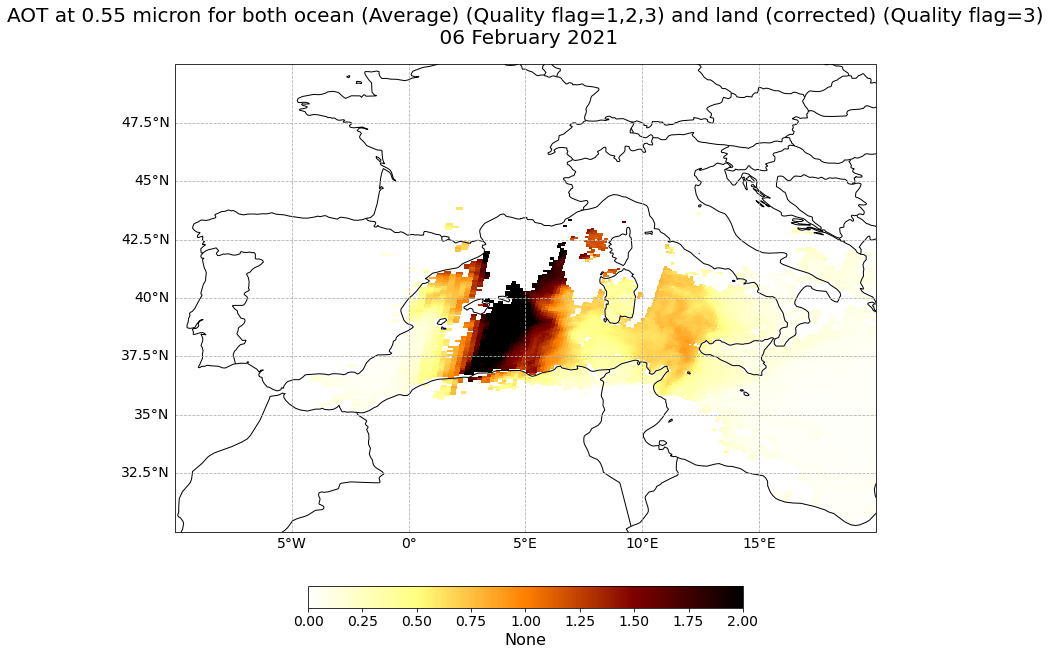

In [16]:
visualize_pcolormesh(data_array=data,
                     longitude=longitude,
                     latitude=latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='afmhot_r',
                     unit=units,
                     long_name=long_name + "\n 06 February 2021",
                     vmin=0, 
                     vmax=2,
                     lonmin=-10,
                     lonmax=20,
                     latmin=30,
                     latmax=50,
                     set_global=False)

<br>

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.